# **Training a CNN to classify the CIFAR-10 dataset**
Adapted from pytorch.org/tutorials : "Training a Classifier"


In [1]:
# libraries we need
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# the whole point of pytorch is to be able to easily train models on GPU's and TPU's
# if you have a dedicated GPU, you can download CUDA from Nvidia toolkits
# this snippet of code will check if you have cuda installed, and will set the 'device' accordingly
# for now, it should probably return "Running on CPU"

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU
Tesla T4


## Data processing

In [3]:
# load the CIFAR 10 training and testing data sets from torchvision.datasets - 10 minutes

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform=torchvision.transforms.ToTensor(), download=True, train=False)

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
# create training and testing loaders
# Hint: this bit of code will be similar to what we wrote last workshop
# experiment with batch sizes, other hyperparams
# 10 minutes 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

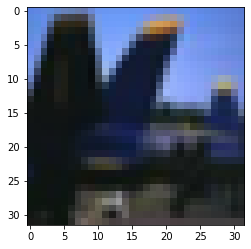

In [5]:
# visualizing a sample
# replace "None" with an iterator constructed from your train loader and run the cell
# to visualize a sample in the set
# 2 min

train_iter = iter(train_loader) # convert your train loader to an iterator

batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

## Building the model

Remember, that CNN's have a typical architecture that involve CONV -> Maxpool -> .... -> FC -> ... Output 

https://pytorch.org/docs/stable/index.html

In [6]:
# construct your CNN model
# we've provided the basic structure of the class you need to implement
# replace all the 'None' statements and add in the architecture of your CNN
# 20 minutes
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # input dim: 3x32x32
        self.c1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        # output dim: 6x32x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # output dim: 6x16x16
        self.c2 = nn.Conv2d(6, 16, 5, 1, 2)
        # output dim: 16x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output dim: 16x8x8
        self.flat = nn.Flatten()
        self.d1 = nn.Linear(16*8*8, 120)
        self.d2 = nn.Linear(120, 84)
        self.d3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.c1(x)))
        x = self.pool2(F.relu(self.c2(x)))
        x = self.flat(x)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x) # no need for softmax
        return x

In [7]:
# create an instance of your class
# 2 minutes
model = CNN()

model.to(device) # specify that this model will be stored on the device you chose earlier (GPU or CPU)

CNN(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (d1): Linear(in_features=1024, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
# choose your loss function. 
# Hint: since we're doing classification, what is a good choice for the loss function?
# 3 minutes
criterion = nn.CrossEntropyLoss()

In [9]:
# choose an optimizer and its hyperparameters
# you can experiment with different choices here and see how it affects the training
# 5 minutes - can revisit this 

optimizer = torch.optim.Adam(model.parameters())

## Training

In [10]:
# create a training function which takes in the pieces you just created
# and runs one epoch  (recall the definition of an epoch)
# 15 minutes

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    losses = []
    # what is the first thing to do before starting training?
    model.train()

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        # main body of your training
        optimizer.zero_grad()
        batch_outputs = model(batch_inputs)
        loss = criterion(batch_outputs, batch_labels)
        loss.backward()
        losses.append(loss)
        optimizer.step()


    print('End of epoch loss:', round((sum(losses)/len(train_dataset)).item(), 3))

## Testing

In [11]:
# 10 minutes
# function to test the model

def test(model, test_loader, device):
    # we've manually specified the classes - these are from the cifar-10 dataset
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


    # what is the first thing to do before testing?
    model.eval()

    correct = 0

    for batch_inputs, batch_labels in test_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
       
        # main body of testing function
        predictions = model(batch_inputs).argmax(axis=1)
        correct += (predictions == batch_labels).sum().item()
        
    print('End of epoch accuracy:', 100*correct/len(test_dataset), '%')
    

    # visualizing the current model's performance - no changes required
    for i in range(4):
        print('Guess:', classes[predictions[i]], '| Label:', classes[batch_labels[i]])
        plt.imshow(batch_inputs[i].cpu().permute(1,2,0))
        plt.show()

# Running the train-test loop

Epoch: 1
End of epoch loss: 0.101
End of epoch accuracy: 50.01 %
Guess: horse | Label: horse


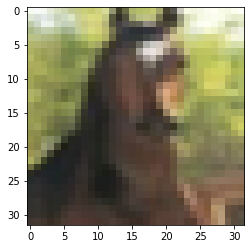

Guess: car | Label: car


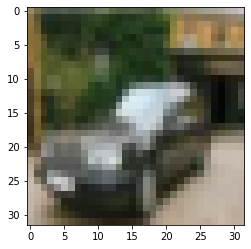

Guess: ship | Label: ship


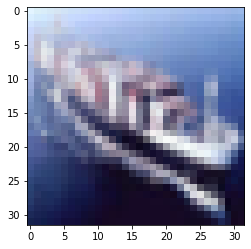

Guess: ship | Label: ship


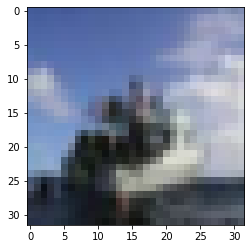

Epoch: 2
End of epoch loss: 0.082
End of epoch accuracy: 52.86 %
Guess: truck | Label: truck


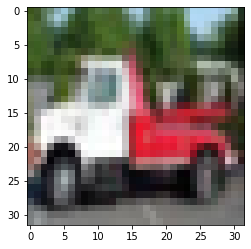

Guess: car | Label: truck


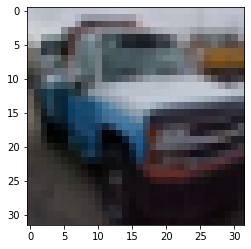

Guess: cat | Label: cat


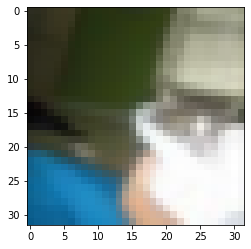

Guess: frog | Label: dog


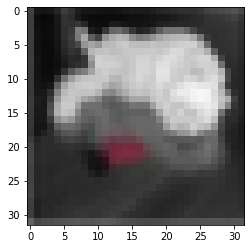

Epoch: 3
End of epoch loss: 0.074
End of epoch accuracy: 58.5 %
Guess: frog | Label: frog


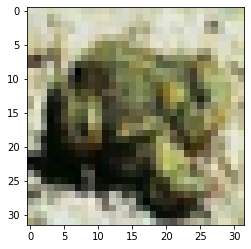

Guess: car | Label: car


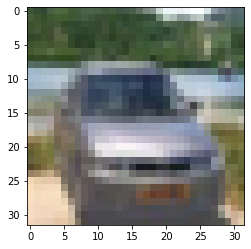

Guess: bird | Label: cat


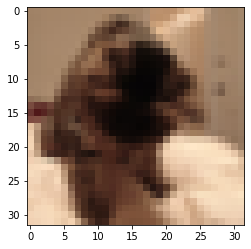

Guess: bird | Label: dog


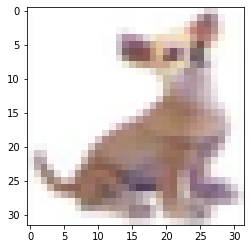

Epoch: 4
End of epoch loss: 0.068
End of epoch accuracy: 60.35 %
Guess: deer | Label: horse


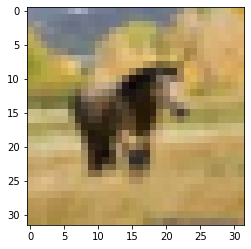

Guess: bird | Label: dog


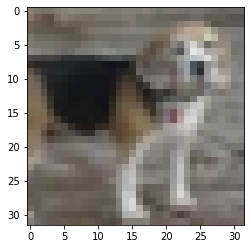

Guess: bird | Label: bird


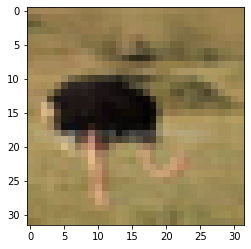

Guess: bird | Label: bird


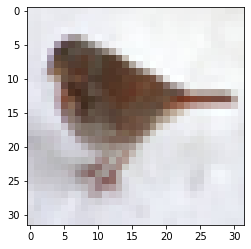

Epoch: 5
End of epoch loss: 0.063
End of epoch accuracy: 60.03 %
Guess: plane | Label: plane


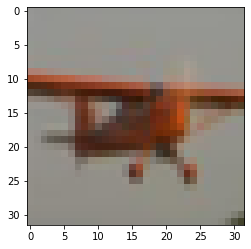

Guess: dog | Label: dog


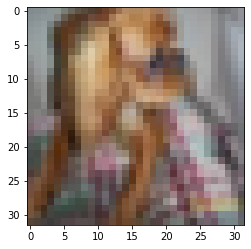

Guess: ship | Label: plane


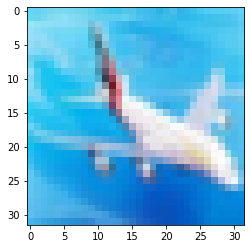

Guess: dog | Label: dog


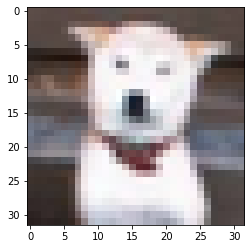

Epoch: 6
End of epoch loss: 0.059
End of epoch accuracy: 62.11 %
Guess: truck | Label: car


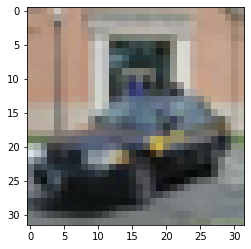

Guess: deer | Label: deer


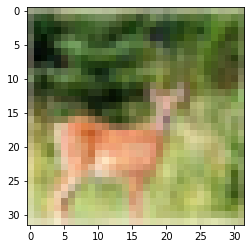

Guess: frog | Label: ship


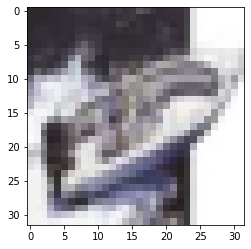

Guess: horse | Label: horse


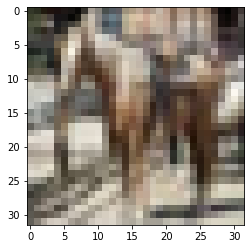

Epoch: 7
End of epoch loss: 0.056
End of epoch accuracy: 61.5 %
Guess: deer | Label: frog


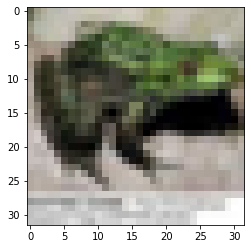

Guess: ship | Label: ship


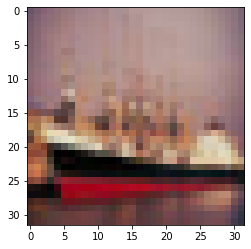

Guess: ship | Label: ship


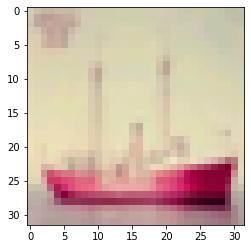

Guess: horse | Label: horse


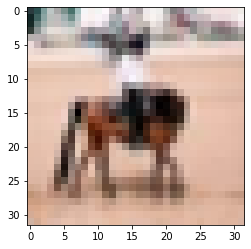

Epoch: 8
End of epoch loss: 0.053
End of epoch accuracy: 62.72 %
Guess: frog | Label: frog


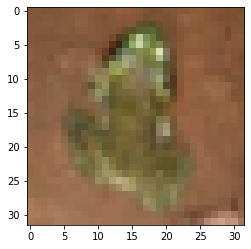

Guess: plane | Label: plane


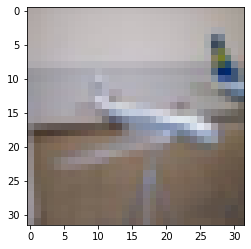

Guess: bird | Label: bird


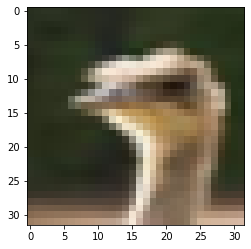

Guess: frog | Label: bird


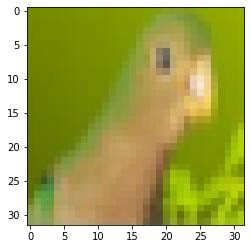

Epoch: 9
End of epoch loss: 0.051
End of epoch accuracy: 63.17 %
Guess: ship | Label: ship


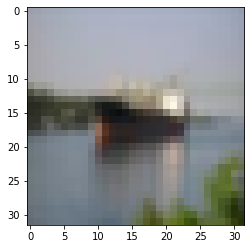

Guess: deer | Label: horse


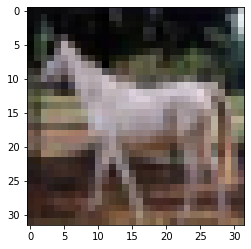

Guess: bird | Label: deer


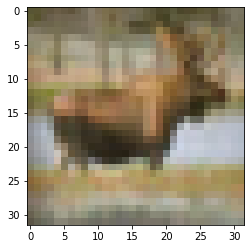

Guess: plane | Label: plane


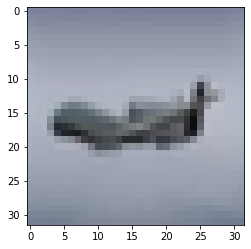

Epoch: 10
End of epoch loss: 0.049
End of epoch accuracy: 63.2 %
Guess: cat | Label: cat


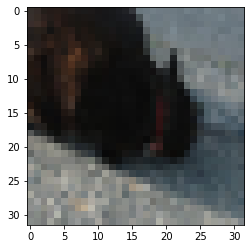

Guess: horse | Label: horse


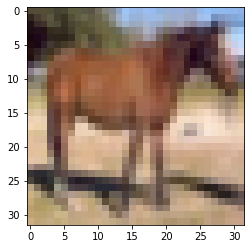

Guess: plane | Label: bird


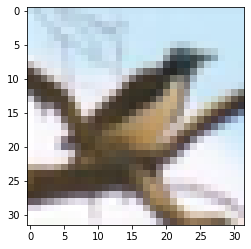

Guess: ship | Label: ship


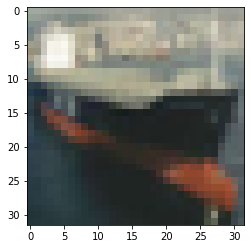

In [12]:
# run a loop which calls the training and testing functions
# you just created
# 5 minutes to code [ and however long to train :) ]

for epoch in range(1, 11):
    print('Epoch:', epoch)
    train_one_epoch(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, device)

## Saving the weights

In [13]:
# save the weights of your model
torch.save(model.state_dict(), './model.pt')

## Loading the weights

In [14]:
# power outage!
# you've lost all your weights.
# or have you?
# reload the weights you just (hopefully) saved
newModel = CNN()
newModel.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>